## Project: Building a Student Intervention System - Supervised Learning

## Author: Hugo Brandão

----
## 1. Introduction

### 1.1. Objective:
My goal for this project is to identify students who might need early intervention before they fail to graduate.

### 1.2. Overview:

As education has grown to rely more on technology, vast amounts of data has become available for examination and prediction. Logs of student activities, grades, interactions with teachers and fellow students, and more, are now captured in real time through learning management systems like **Canvas** and **Edmodo**. This is especially true for online classrooms, which are becoming popular even at the primary and secondary school level. Within all levels of education, there exists a push to help increase the likelihood of student success, without watering down the education or engaging in behaviors that fail to improve the underlying issues. Graduation rates are often the criteria of choice, and educators seek new ways to predict the success and failure of students early enough to stage effective interventions.


### 1.3 Description:

A local school district has a goal to reach a 95% graduation rate by the end of the decade by identifying students who need intervention before they drop out of school. As a software engineer contacted by the school district, my task is to model the factors that predict how likely a student is to pass their high school final exam, by constructing an intervention system that leverages supervised learning techniques. The board of supervisors has asked that I find the most effective model that uses the least amount of computation costs to save on the budget. I will need to analyze the dataset on students' performance and develop a model that will predict the likelihood that a given student will pass, quantifying whether an intervention is necessary.

### 1.4. Dataset:
Some of the columns of this dataset are:
* sex
* address
* famsize: number of family members
* traveltime: travel time between school and home
* studytime: weeks hours of study

## 2. Exploring the Data
Load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read student data
student_data = pd.read_csv("student-data.csv")

In [2]:
# Calculate number of students
n_students = student_data.shape[0]

# Calculate number of features
n_features = student_data.shape[1] - 1

# Calculate passing students
n_passed = student_data[student_data['passed']=='yes'].shape[0]

# Calculate failing students
n_failed = student_data[student_data['passed']=='no'].shape[0]

# Calculate graduation rate
grad_rate = n_passed / n_students * 100

# Print the results
print("Total number of students: \t{}".format(n_students))
print("Number of features: \t\t{}".format(n_features))
print("Number of students who passed: \t{}".format(n_passed))
print("Number of students who failed: \t{}".format(n_failed))
print("Graduation rate of the class: \t{:.2f}%".format(grad_rate))

Total number of students: 	395
Number of features: 		30
Number of students who passed: 	265
Number of students who failed: 	130
Graduation rate of the class: 	67.09%


** The Dataset is quite unbalanced as the number of passed students >> number of failed students.** Note these numbers are particularly important since they describe the main dataset characteristics:

- The small and unbalanced dataset is why **StratifiedShuffleSplit** instead of a simpler cross-validation method such as TrainTestSplit is preferred. StratifiedShuffleSplit will make randomly chosen training and test sets multiple times and average the results over all the tests.

- The data is unbalanced and that is why it is required to use precision and recall (or F1, harmonic mean of them) instead of accuracy as our evaluation metric.

### 2.1. Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, I will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).

In [3]:
student_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000


In [4]:
student_data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')

In [5]:
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


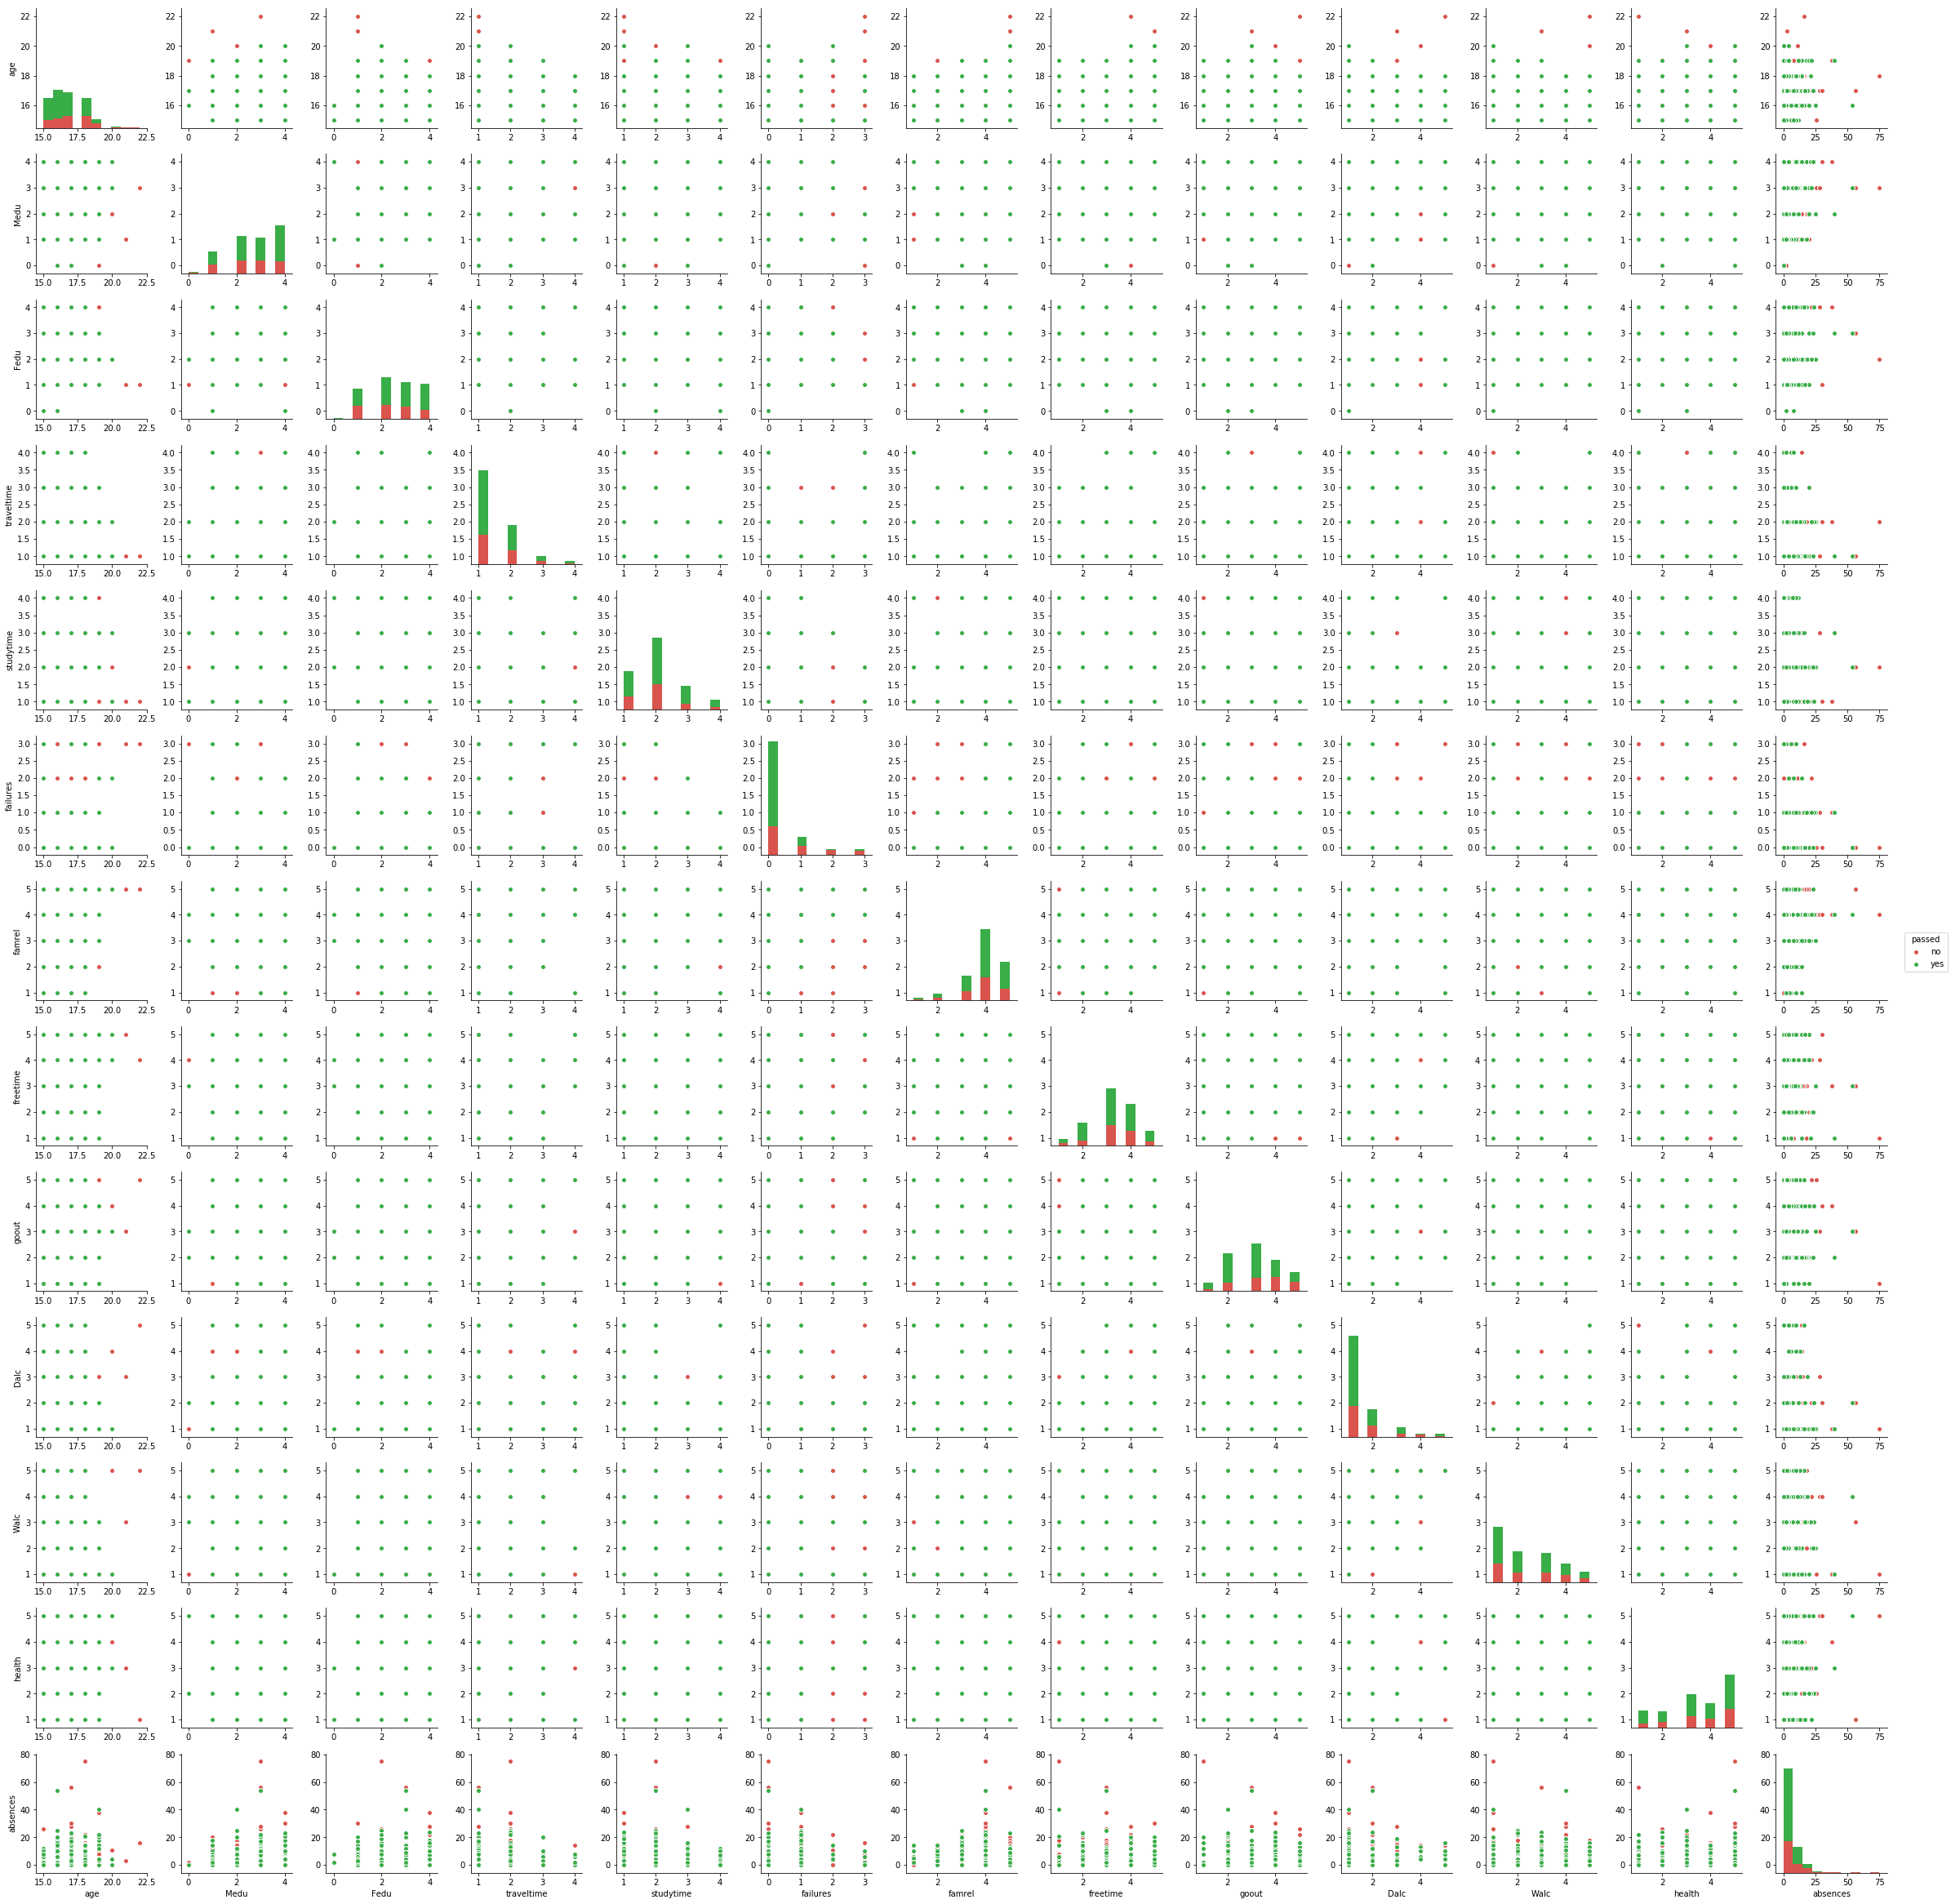

In [6]:
# Color Names: https://xkcd.com/color/rgb/
sns.pairplot(student_data, hue='passed', palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]])

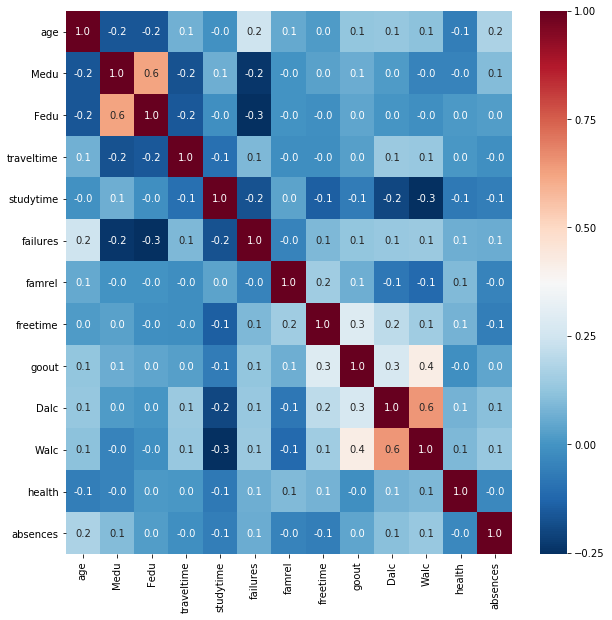

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(student_data.corr(), cmap='RdBu_r', annot=True, fmt='.1f')

## 3. Preparing the Data
In this section, I will prepare the data for modeling, training and testing.

### 3.1. Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

The code cell below will separate the student data into feature and target columns to see if any features are non-numeric.

In [8]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### 3.2. Preprocess Feature Columns

As you can see, there are several **non-numeric columns** that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as **categorical variables**. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. 

The code cell below performs he preprocessing routine discussed in this section.

In [10]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical (and was not 'yes/no', convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [11]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


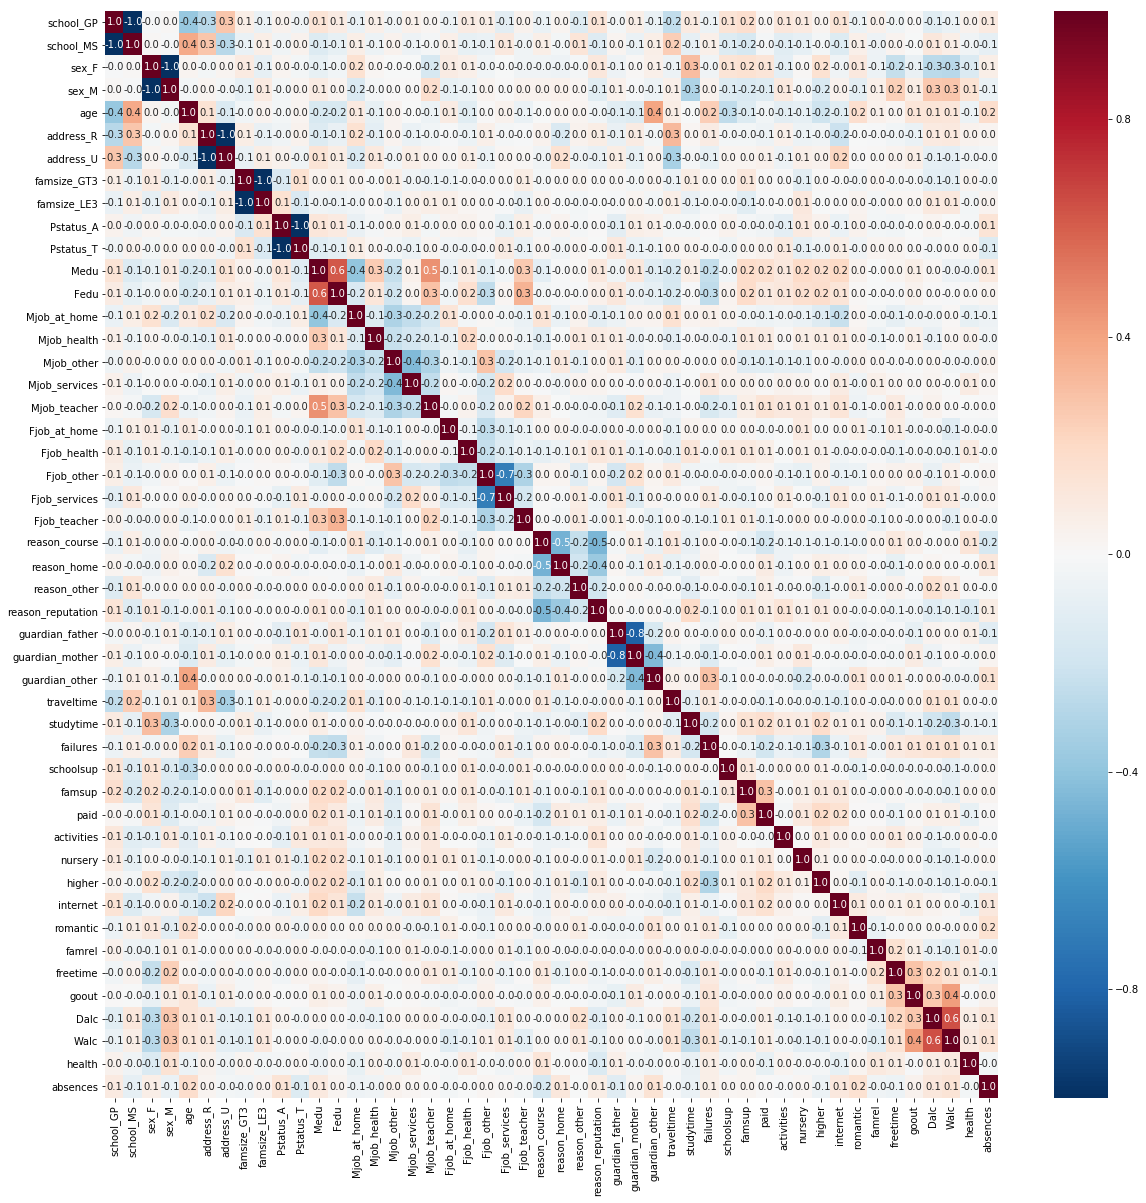

In [13]:
student_data2 = pd.concat([X_all, y_all], axis=1)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(student_data2.corr(), cmap='RdBu_r', annot=True, fmt='.1f')

### 3.3 Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, I will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) I use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Import any additional functionality I may need here
from sklearn.model_selection import train_test_split

# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_train / (num_train + num_test), random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

## 4. Training and Evaluating Models
In this section, I will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. I will first discuss the reasoning behind choosing these three models by considering what I know about the data and each model's strengths and weaknesses. I will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. I will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that I may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

**1. KNN:**
- ** Real Word Applications:** Recommendation systems. [Source 1](https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c), [Source 2](http://rnowling.github.io/data/science/2016/10/29/knn-recsys.html).


- ** Strengths:**
 - Simple to understand and easy to implement.
 - With zero to little training time. 
 - Non parametric model, which  means that it does not make any assumptions on the underlying data distribution.
 - Robust to noisy training data.
 
 
- ** Weakness:**
 - Lazy learner. High computational cost: 1) Neds large storage space for keeping training data and 2) Computationally expensive testing phase which is impractical in industry settings.
 - Select the optimal k is difficult.
 - KNN can suffer from skewed class distributions. For example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common).
 - The accuracy of KNN can be severely degraded with high-dimension data because there is little difference between the nearest and farthest neighbor.
  - Requires scaled features.


- ** Why is a good candidate?** Because it is simple and it is a non parametric model, which  means that it does not make any assumptions on the underlying data distribution.

<BR></BR>


**2. SVM:**
- ** Real Word Applications:** Face Detection, Text and Hypertext Categorization, Classification of Images. [Source](https://data-flair.training/blogs/applications-of-svm/).


- ** Strengths:** 
  - Works really well with clear margin of separation.
  - Effective in high dimensional spaces.
  - Effective in cases where number of dimensions is greater than the number of samples.
  - Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
  - Works well with clear margin separation of data.
  - Kernel trick allows separating linear and non-linear data.
  
  
- ** Weakness:** 
 - It doesn’t perform well when we have large data set because the required training time is higher.
 - It also doesn’t perform very well when the data set has more noise i.e. target classes are overlapping.
 - Requires scaled features.
 - Probability estimates are provided with a 5 fold CV (very slow!).
 - SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. 
 - Susceptible to overfitting/training issues depending on kernel.


- ** Why is a good candidate?** Effective in high dimensional spaces. The student data set contains 48 features which seems a high number when compared to 395 records of the data set.

<BR></BR>

**3. Bagging Classifier:**
- ** Real Word Application:** Remote sensing, person recognition, one vs. all recognition, and medicine. [Source](https://pdfs.semanticscholar.org/7db2/1481c37237dd9e2a2547c880917dd14740b0.pdf)



- ** Strengths:** 
 - Reduces variance in comparison to regular decision trees.
 - Robustness to outliers in output space (not in the case of Boosting).
 - More accurate than simpler algorithms.
 

- ** Weakness:**
 - Not as easy to visually interpret. 
 - Does not reduce variance if the features are correlated.
 - Computationally speaking is expensive
 - Hard to interpret. 


- ** Why is a good candidate?** Features are not correlected as seen in the heat map above.

### 4.1. Setup
The code cell below will initialize three helper functions which can be used for training and testing the three supervised learning models I've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [93]:
from sklearn.metrics import classification_report

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
        
    return f1_score(target.values, y_pred, pos_label='yes')
    #return


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    print(clf)
    
    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(f1_score(y_train, clf.predict(X_train), pos_label='yes')))
    print("F1 score for test set: {:.4f}.".format(f1_score(y_test, clf.predict(X_test), pos_label='yes')))

    print("Classification Report for training set: \n{}.".format(classification_report(y_train, clf.predict(X_train))))
    print("Classification Report for test set: \n{}.".format(classification_report(y_test, clf.predict(X_test))))

### 4.2 Implementation: Model Performance Metrics
With the predefined functions above, I will now import the three supervised learning models of my choice and run the `train_predict` function for each one. Remember that I will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, I should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, I will need to implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model I use.
 - **Note:** Use the default settings for each model — I will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store my results.

In [94]:
# Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import train_test_split

clf_NB = GaussianNB()
clf_Bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
clf_KNN = KNeighborsClassifier(n_neighbors=7)
clf_SVM = svm.SVC()

# Set up the training set sizes
X_train_100 = 100
y_train_100 = n_students - X_train_100
X_train_200 = 200
y_train_200 = n_students - X_train_200
X_train_300 = 300
y_train_300 = n_students - X_train_300
 
classifiers = [clf_KNN, clf_SVM, clf_Bagging]

test_sizes = [395-100, 395-200, 395-300]

for clf in classifiers:
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                            test_size=test_size/395.0,
                                                            random_state=42)
        train_predict(clf, X_train, y_train, X_test, y_test)
        print("\n")
    print("-------\n")

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
F1 score for training set: 0.8366.
F1 score for test set: 0.7859.
Classification Report for training set: 
             precision    recall  f1-score   support

         no       0.79      0.33      0.47        33
        yes       0.74      0.96      0.84        67

avg / total       0.76      0.75      0.71       100
.
Classification Report for test set: 
             precision    recall  f1-score   support

         no       0.50      0.21      0.29        97
        yes       0.70      0.90      0.79       198

avg / total       0.63      0.67      0.62       295
.


Training a KNeighborsClassifier using a training set size of 200. . .
Trained model in 0.0010 seconds
KNeighborsClassifier(algorithm='auto', leaf_size=30, m

### 4.3. Tabular Results

** Classifer 1 - KNN**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) | Recall (\*) (test)
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: |
| 100               | 0.0000                  | 0.0030                 |  0.8366          |  0.7859         | 0.90
| 200               | 0.0010                  | 0.0030                 |  0.8626          |  0.7841         | 0.95
| 300               | 0.0010                  | 0.0030                 |  0.8540          |  0.7338         | 0.85

** Classifer 2 - SVM**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) | Recall (\*) (test)
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: |
| 100               | 0.0010                  | 0.0020                 |  0.8481          |  0.8115         | 1.00
| 200               | 0.0040                  | 0.0020                 |  0.8868          |  0.8013         | 0.99
| 300               | 0.0090                  | 0.0030                 |  0.8761          |  0.7838         | 0.97

** Classifer 3 - Bagging (KNN) **  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) | Recall (\*) (test)
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: |
| 100               | 0.0080                  | 0.0121                 |  0.8302          |  0.8068         | 1.00
| 200               | 0.0060                  | 0.0111                 |  0.8485          |  0.7922         | 0.98
| 300               | 0.0080                  | 0.0091                 |  0.8553          |  0.7534         | 0.98


**Note (\*): ** Recall for 'Yes' label in Testing Set, that is, Recall measures out of all the students in Testing Set, how many students who needed intervetion did the model identified.

## 5. Choosing the Best Model
In this final section, I will choose from the three supervised learning models the *best* model to use on the student data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
Based on the experiments we performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?

**Answer: **

**Recall** is the most important performance metric for this problem as we need to identify as many students who need intervetion as possible. On the other hand, **Precision** will give us the number of studens who actually need intervetion out of all students selected for intervetion (not necessarily all who do need intervention). For some models, we could get a high Precision, but that may represent just identify a small percentage of students who really need intervetion and we would be missing a lot of students who actually needs intervetion. So this performance metric for this problem can be tricky. Because of that, **F1-Score**, which is the harmonic average of the precision and recall, should not be the primarily performance metric.

That being said, SVM's Recall beats or equals to KNN's and Bagging's for Training Set Sizes of 100 and 200. One important highlight here is that both SVM and Bagging have 100% Recal scores  for Training Set Size of 100 which is quite small (around 25% of total student population). SVM also performs better on Prediction Time. For those reasons, SVM would be my first choice of algorithm to tackle this problem.

### Question 4 - Model in Layman's Terms
In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.

**Answer: **

SVMs are based on the idea of finding a hyperplane that best divides a dataset into two classes, as shown in the image below. As a simple example, for a classification task with only two features (x and y, like in the image below), you can think of a hyperplane as a line that linearly separates and classifies a set of data.

<img src="SVM.png">


Intuitively, the further from the hyperplane our data points lie, the more confident we are that they have been correctly classified. So when new testing data is added, whatever side of the hyperplane it lands will decide the class that we assign to it.


SVM is effective in high dimensional spaces, that is, it works well with the student data set which contains 48 student's features which seems a high number when compared to 395 records of the data set. Its other benefits are: 1) Memory efficient, 2) Works well with clear margin separation of data and 3) Separate well linear and non-linear data (data with complex relationship among data elements).

### 5.1. Implementation: Model Tuning
Fine tune the chosen model. I wil use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I will need to use the entire training set for this. In the code cell below, I will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters I wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier I've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [112]:
# Set Training Set to 100 records and Testing Set to 296 records
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                            test_size=295.0/395.0,
                                                            random_state=42)

# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Create the parameters list to be tuned
parameters = {'C' : [0.001, 0.01, 0.1, 1, 10],
              #'gamma' : [0.001, 0.01, 0.1, 1],
              #'kernel': ['linear', 'rbf']}
              'kernel': ['rbf']}

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(svm.SVC(), parameters, scoring=f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

print(clf)

# Report the final F1 score for training and testing after parameter tuning
print('Tuned model has a training F1 score of {:.4f}.'.format(predict_labels(clf, X_train, y_train)))
print('Tuned model has a testing F1 score of {:.4f}.'.format(predict_labels(clf, X_test, y_test)))

print("Classification Report for training set: \n{}.".format(classification_report(y_train, clf.predict(X_train))))
print("Classification Report for test set: \n{}.".format(classification_report(y_test, clf.predict(X_test))))

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Made predictions in 0.0000 seconds.
Tuned model has a training F1 score of 0.8024.
Made predictions in 0.0020 seconds.
Tuned model has a testing F1 score of 0.8032.
Classification Report for training set: 
             precision    recall  f1-score   support

         no       0.00      0.00      0.00        33
        yes       0.67      1.00      0.80        67

avg / total       0.45      0.67      0.54       100
.
Classification Report for test set: 
             precision    recall  f1-score   support

         no       0.00      0.00      0.00        97
        yes       0.67      1.00      0.80       198

avg / total       0.45      0.67      0.54       295
.


C:\Users\hugo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Question 5 - Final F<sub>1</sub> Score
What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?

**Answer: **

Grid Search has not improved the F1 Score. Probably there is something wrong with it.